In [1]:
import tensorflow as tf
import time
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import csv
#%matplotlib inline 

In [2]:
def batch_norm(X, scale, offset, axes, is_train, device_name='/cpu:0'):
    # 予測のときにはそのまんまの値を返す
    if is_train is False:
        return X

    epsilon = 1e-5
    with tf.device(device_name):
        mean, variance = tf.nn.moments(X, axes)
        bn = tf.nn.batch_normalization(X, mean, variance, offset, scale,
                                       epsilon)

    return bn


class Generator():
    def __init__(self, device_name='/cpu:0'):

        # Generator parameter
        with tf.device(device_name):
            self.gen_w1 = tf.Variable(
                tf.truncated_normal(
                    shape=[50, 64], stddev=0.02, dtype=tf.float32),
                name="gen_w1")
            self.gen_b1 = tf.Variable(
                tf.truncated_normal(shape=[64], stddev=0.02, dtype=tf.float32),
                name="gen_b1")

            self.gen_w2 = tf.Variable(
                tf.truncated_normal([64, 128], stddev=0.02, dtype=tf.float32),
                name="gen_w2")
            self.gen_b2 = tf.Variable(
                tf.truncated_normal(
                    shape=[128], stddev=0.02, dtype=tf.float32),
                name="gen_b2")

            self.gen_w3 = tf.Variable(
                tf.truncated_normal([128, 2], stddev=0.02, dtype=tf.float32),
                name="gen_w3")
            self.gen_b3 = tf.Variable(
                tf.truncated_normal(shape=[2], stddev=0.02, dtype=tf.float32),
                name="gen_b3")

            self.keep_prob = tf.placeholder(tf.float32)

    def run(self, z, is_train, device_name='/cpu:0'):

        with tf.device(device_name):
            h1 = tf.nn.leaky_relu(
                tf.nn.xw_plus_b(z, self.gen_w1, self.gen_b1), alpha=0.2)

            h2 = tf.nn.leaky_relu(
                tf.nn.xw_plus_b(h1, self.gen_w2, self.gen_b2), alpha=0.2)

            fc = tf.tanh(tf.nn.xw_plus_b(h2, self.gen_w3, self.gen_b3))
        return fc


class Discrimitor():
    def __init__(self, device_name='/cpu:0'):
        # Discrimitor parameter
        with tf.device(device_name):
            self.dis_w1 = tf.Variable(
                tf.truncated_normal([2, 128], stddev=0.02, dtype=tf.float32),
                name="dis_w1")
            self.dis_b1 = tf.Variable(
                tf.truncated_normal([128], stddev=0.02, dtype=tf.float32),
                name="dis_b1")

            self.dis_w2 = tf.Variable(
                tf.truncated_normal([128, 64], stddev=0.02, dtype=tf.float32),
                name="dis_w2")
            self.dis_b2 = tf.Variable(
                tf.truncated_normal([64], stddev=0.02, dtype=tf.float32),
                name="dis_b2")

            self.dis_w3 = tf.Variable(
                tf.truncated_normal([64, 1], stddev=0.02, dtype=tf.float32),
                name="dis_w3")
            self.dis_b3 = tf.Variable(
                tf.truncated_normal([1], stddev=0.02, dtype=tf.float32),
                name="dis_b3")

            # For tmp discriminator params
            self.copy_dis_w1 = tf.placeholder(
                dtype=self.dis_w1.dtype, shape=self.dis_w1.shape)
            self.copy_dis_w2 = tf.placeholder(
                dtype=self.dis_w2.dtype, shape=self.dis_w2.shape)
            self.copy_dis_w3 = tf.placeholder(
                dtype=self.dis_w3.dtype, shape=self.dis_w3.shape)
            self.copy_dis_b1 = tf.placeholder(
                dtype=self.dis_b1.dtype, shape=self.dis_b1.shape)
            self.copy_dis_b2 = tf.placeholder(
                dtype=self.dis_b2.dtype, shape=self.dis_b2.shape)
            self.copy_dis_b3 = tf.placeholder(
                dtype=self.dis_b3.dtype, shape=self.dis_b3.shape)

    def run(self, x, device_name='/cpu:0'):

        with tf.device(device_name):
            h1 = tf.nn.leaky_relu(
                tf.nn.xw_plus_b(x, self.dis_w1, self.dis_b1), alpha=0.2)

            h2 = tf.nn.leaky_relu(
                tf.nn.xw_plus_b(h1, self.dis_w2, self.dis_b2), alpha=0.2)

            fc = tf.nn.sigmoid(tf.nn.xw_plus_b(h2, self.dis_w3, self.dis_b3))

        return fc


class UnrolledGAN():
    def __init__(self, using_gpu):
        self.device_name = '/cpu:0'
        if (using_gpu):
            self.device_name = '/gpu:0'

        print('using : {}'.format(self.device_name))

        with tf.device(self.device_name):

            self.is_train = tf.placeholder(tf.bool)
            self.input_X = tf.placeholder(tf.float32, shape=(None, 2))

            # t0は0のラベルを格納し、t1は1のラベルを格納する
            self.label_t0 = tf.placeholder(tf.float32, shape=(None, 1))
            self.label_t1 = tf.placeholder(tf.float32, shape=(None, 1))

            # Generator
            self.generator = Generator(device_name=self.device_name)
            # 生成モデルに必要なノイズの入れ物
            self.gen_z = tf.placeholder(tf.float32, shape=(None, 50))

            # Discrimitor
            self.discrimitor = Discrimitor(device_name=self.device_name)

            # 訓練データの識別予測
            input_X = self.discrimitor.run(
                self.input_X, device_name=self.device_name)
            # 生成されたデータの識別予測
            generated_X = self.discrimitor.run(
                self.generator.run(
                    z=self.gen_z,
                    is_train=self.is_train,
                    device_name=self.device_name))

            self.dis_entropy_X = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self.label_t1, logits=input_X)
            self.dis_entropy_G = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self.label_t0, logits=generated_X)
            self.dis_loss = tf.reduce_mean(self.dis_entropy_X + self.dis_entropy_G)

            self.gen_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self.label_t1, logits=generated_X)
            self.gen_loss = tf.reduce_mean(self.gen_entropy)

            # 最適化する際にDならDのみのパラメータを、GならGのみのパラメータを更新するようにしたいのでモデル別の変数を取得する
            dis_vars = [
                x for x in tf.trainable_variables() if "dis_" in x.name
            ]
            gen_vars = [
                x for x in tf.trainable_variables() if "gen_" in x.name
            ]

            # 識別モデルDの最適化
            self.opt_d = tf.train.AdamOptimizer(
                0.0002, beta1=0.25).minimize(
                    self.dis_loss, var_list=[dis_vars])
            # 生成モデルGの最適化
            self.opt_g = tf.train.AdamOptimizer(
                0.002, beta1=0.5).minimize(
                    self.gen_loss, var_list=[gen_vars])

    def train(self,
              X_train=None,
              batch_size=100,
              epoch_num=1000,
              unrolled_step=5,
              imgpath='./NormalDist_UnrolledGAN_images/',
              ckptpath='./NormaiDist_UnrolledGAN_checkpoints/',
              log_file='NormalDist_UnrolledGAN_loss_log.csv',
              init=False):

        if X_train is None:
            raise TypeError("X_train is None")

        # 訓練途中で生成データを作成して保存したいのでその保存先の作成
        p = Path(imgpath)
        if not (p.is_dir()):
            p.mkdir()

        # モデルパラメータのチェックポイントの保存先
        ckpt_p = Path(ckptpath)
        if not (ckpt_p.is_dir()):
            ckpt_p.mkdir()

        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True

        saver = tf.train.Saver()

        sess = tf.Session()

        if (init):
            sess.run(tf.global_variables_initializer())
            print('Initialize')

        ckpt = tf.train.get_checkpoint_state(str(ckpt_p.absolute()))
        if ckpt:
            # checkpointファイルから最後に保存したモデルへのパスを取得する
            last_model = ckpt.model_checkpoint_path
            print("load {0}".format(last_model))
            # 学習済みモデルを読み込む
            saver.restore(sess, last_model)

        step = len(X_train) // batch_size

        # 正解ラベルのミニバッチ
        t1_batch = np.ones((batch_size, 1), dtype=np.float32)
        t0_batch = np.zeros((batch_size, 1), dtype=np.float32)

        # Unrolledする前のDiscriminatorのパラメータを復元するためのオペレーション
        restore_dis_w1 = tf.assign(self.discrimitor.dis_w1,
                                   self.discrimitor.copy_dis_w1)
        restore_dis_w2 = tf.assign(self.discrimitor.dis_w2,
                                   self.discrimitor.copy_dis_w2)
        restore_dis_w3 = tf.assign(self.discrimitor.dis_w3,
                                   self.discrimitor.copy_dis_w3)
        restore_dis_b1 = tf.assign(self.discrimitor.dis_b1,
                                   self.discrimitor.copy_dis_b1)
        restore_dis_b2 = tf.assign(self.discrimitor.dis_b2,
                                   self.discrimitor.copy_dis_b2)
        restore_dis_b3 = tf.assign(self.discrimitor.dis_b3,
                                   self.discrimitor.copy_dis_b3)

        for epoch in range(epoch_num):

            perm = np.random.permutation(len(X_train))
            # １エポックごとにかかる時間の計測
            start = time.time()
            for s in range(step):

                X_batch = X_train[perm][s * batch_size:(s + 1) * batch_size]

                # Train Discrimitor
                # ノイズ事前分布からノイズをミニバッチ分取得
                noise_z = np.random.uniform(
                    -1, 1, size=[batch_size, 50]).astype(np.float32)

                sess.run(
                    self.opt_d,
                    feed_dict={
                        self.input_X: X_batch,
                        self.is_train: False,
                        self.gen_z: noise_z,
                        self.generator.keep_prob: 1.0,
                        self.label_t1: t1_batch,
                        self.label_t0: t0_batch
                    })

                # copy discriminator parameters
                copy_dis_w1 = sess.run(self.discrimitor.dis_w1)
                copy_dis_w2 = sess.run(self.discrimitor.dis_w2)
                copy_dis_w3 = sess.run(self.discrimitor.dis_w3)

                copy_dis_b1 = sess.run(self.discrimitor.dis_b1)
                copy_dis_b2 = sess.run(self.discrimitor.dis_b2)
                copy_dis_b3 = sess.run(self.discrimitor.dis_b3)

                # Unrolled step for discriminator
                for k in range(unrolled_step):

                    sess.run(
                        self.opt_d,
                        feed_dict={
                            self.input_X: X_batch,
                            self.is_train: False,
                            self.gen_z: noise_z,
                            self.generator.keep_prob: 1.0,
                            self.label_t1: t1_batch,
                            self.label_t0: t0_batch
                        })

                sess.run(
                    self.opt_g,
                    feed_dict={
                        self.gen_z: noise_z,
                        self.is_train: True,
                        self.generator.keep_prob: 0.5,
                        self.label_t1: t1_batch,
                        self.label_t0: t0_batch
                    })

                # restore discriminator parameter previous unrolled step
                sess.run(
                    restore_dis_w1,
                    feed_dict={self.discrimitor.copy_dis_w1: copy_dis_w1})
                sess.run(
                    restore_dis_w2,
                    feed_dict={self.discrimitor.copy_dis_w2: copy_dis_w2})
                sess.run(
                    restore_dis_w3,
                    feed_dict={self.discrimitor.copy_dis_w3: copy_dis_w3})

                sess.run(
                    restore_dis_b1,
                    feed_dict={self.discrimitor.copy_dis_b1: copy_dis_b1})
                sess.run(
                    restore_dis_b2,
                    feed_dict={self.discrimitor.copy_dis_b2: copy_dis_b2})
                sess.run(
                    restore_dis_b3,
                    feed_dict={self.discrimitor.copy_dis_b3: copy_dis_b3})

            # 1epoch終了時の損失を表示
            noise_z = np.random.uniform(
                -1, 1, size=[batch_size, 50]).astype(np.float32)

            train_dis_loss = sess.run(
                self.dis_loss,
                feed_dict={
                    self.input_X: X_batch,
                    self.is_train: False,
                    self.gen_z: noise_z,
                    self.generator.keep_prob: 1.0,
                    self.label_t1: t1_batch,
                    self.label_t0: t0_batch
                })

            train_gen_loss = sess.run(
                self.gen_loss,
                feed_dict={
                    self.gen_z: noise_z,
                    self.is_train: False,
                    self.generator.keep_prob: 1.0,
                    self.label_t1: t1_batch,
                    self.label_t0: t0_batch
                })

            print(
                "[Train] epoch: %d, dis loss: %f , gen loss : %f  Time : %f" %
                (epoch, train_dis_loss, train_gen_loss, time.time() - start))

            f = open(log_file, 'a')
            log_writer = csv.writer(f, lineterminator='\n')
            loss_list = []
            loss_list.append(epoch)
            loss_list.append(train_dis_loss)
            loss_list.append(train_gen_loss)
            # 損失の値を書き込む
            log_writer.writerow(loss_list)
            f.close()

            # 10epoch終了毎に生成モデルから800個の点を生成して描画する
            if epoch % 10 == 0:
                noise_z = np.random.uniform(
                    -1, 1, size=[800, 50]).astype(np.float32)

                #z_const = tf.constant(noise_z, dtype=tf.float32)
                gen_points = sess.run(
                    self.generator.run(self.gen_z, is_train=False),
                    feed_dict={
                        self.gen_z: noise_z,
                        self.generator.keep_prob: 1.0
                    })

                plt.figure(1)
                plt.xlim([-1, 1])
                plt.ylim([-1, 1])
                plt.grid(True)

                plt.plot(
                    gen_points[:, 0], gen_points[:, 1], 'bo', markersize=1)

                plt.savefig(
                    str(p.absolute()) +
                    '/generate_points_epoch{0}.jpg'.format(epoch))

                plt.close()

            if epoch % 20 == 0:
                saver.save(sess, str(ckpt_p.absolute()) + '/UnrolledGAN')

In [3]:
rand_x = np.random.normal(scale=0.01,size=(400,1))
rand_y  = np.random.normal(scale=0.01,size=(400,1))

data1 = np.concatenate([rand_x+0.75,rand_y], axis=1)
data2 = np.concatenate([rand_x-0.75,rand_y], axis=1)
data3 = np.concatenate([rand_x,rand_y+0.75], axis=1)
data4 = np.concatenate([rand_x,rand_y-0.75], axis=1)
data5 = np.concatenate([rand_x+0.5,rand_y+0.5], axis=1)
data6 = np.concatenate([rand_x-0.5,rand_y+0.5], axis=1)
data7 = np.concatenate([rand_x+0.5,rand_y-0.5], axis=1)
data8 = np.concatenate([rand_x-0.5,rand_y-0.5], axis=1)

X_train = np.r_[data1,data2,data3,data4,data5,data6,data7,data8]
len(X_train)

3200

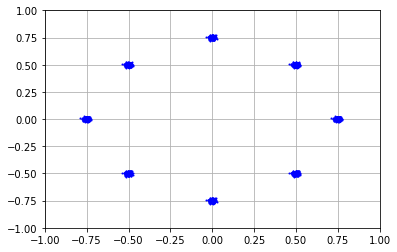

In [4]:
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.grid(True)

plt.plot(X_train[:,0], X_train[:,1],'bo',markersize=1)

plt.show()
plt.close()

In [5]:
model = UnrolledGAN(using_gpu=False)

using : /cpu:0


In [ ]:
model.train(
    X_train=X_train,
    batch_size=100,
    epoch_num=1001,
    unrolled_step=5,
    init=True)

In [6]:
%matplotlib inline 

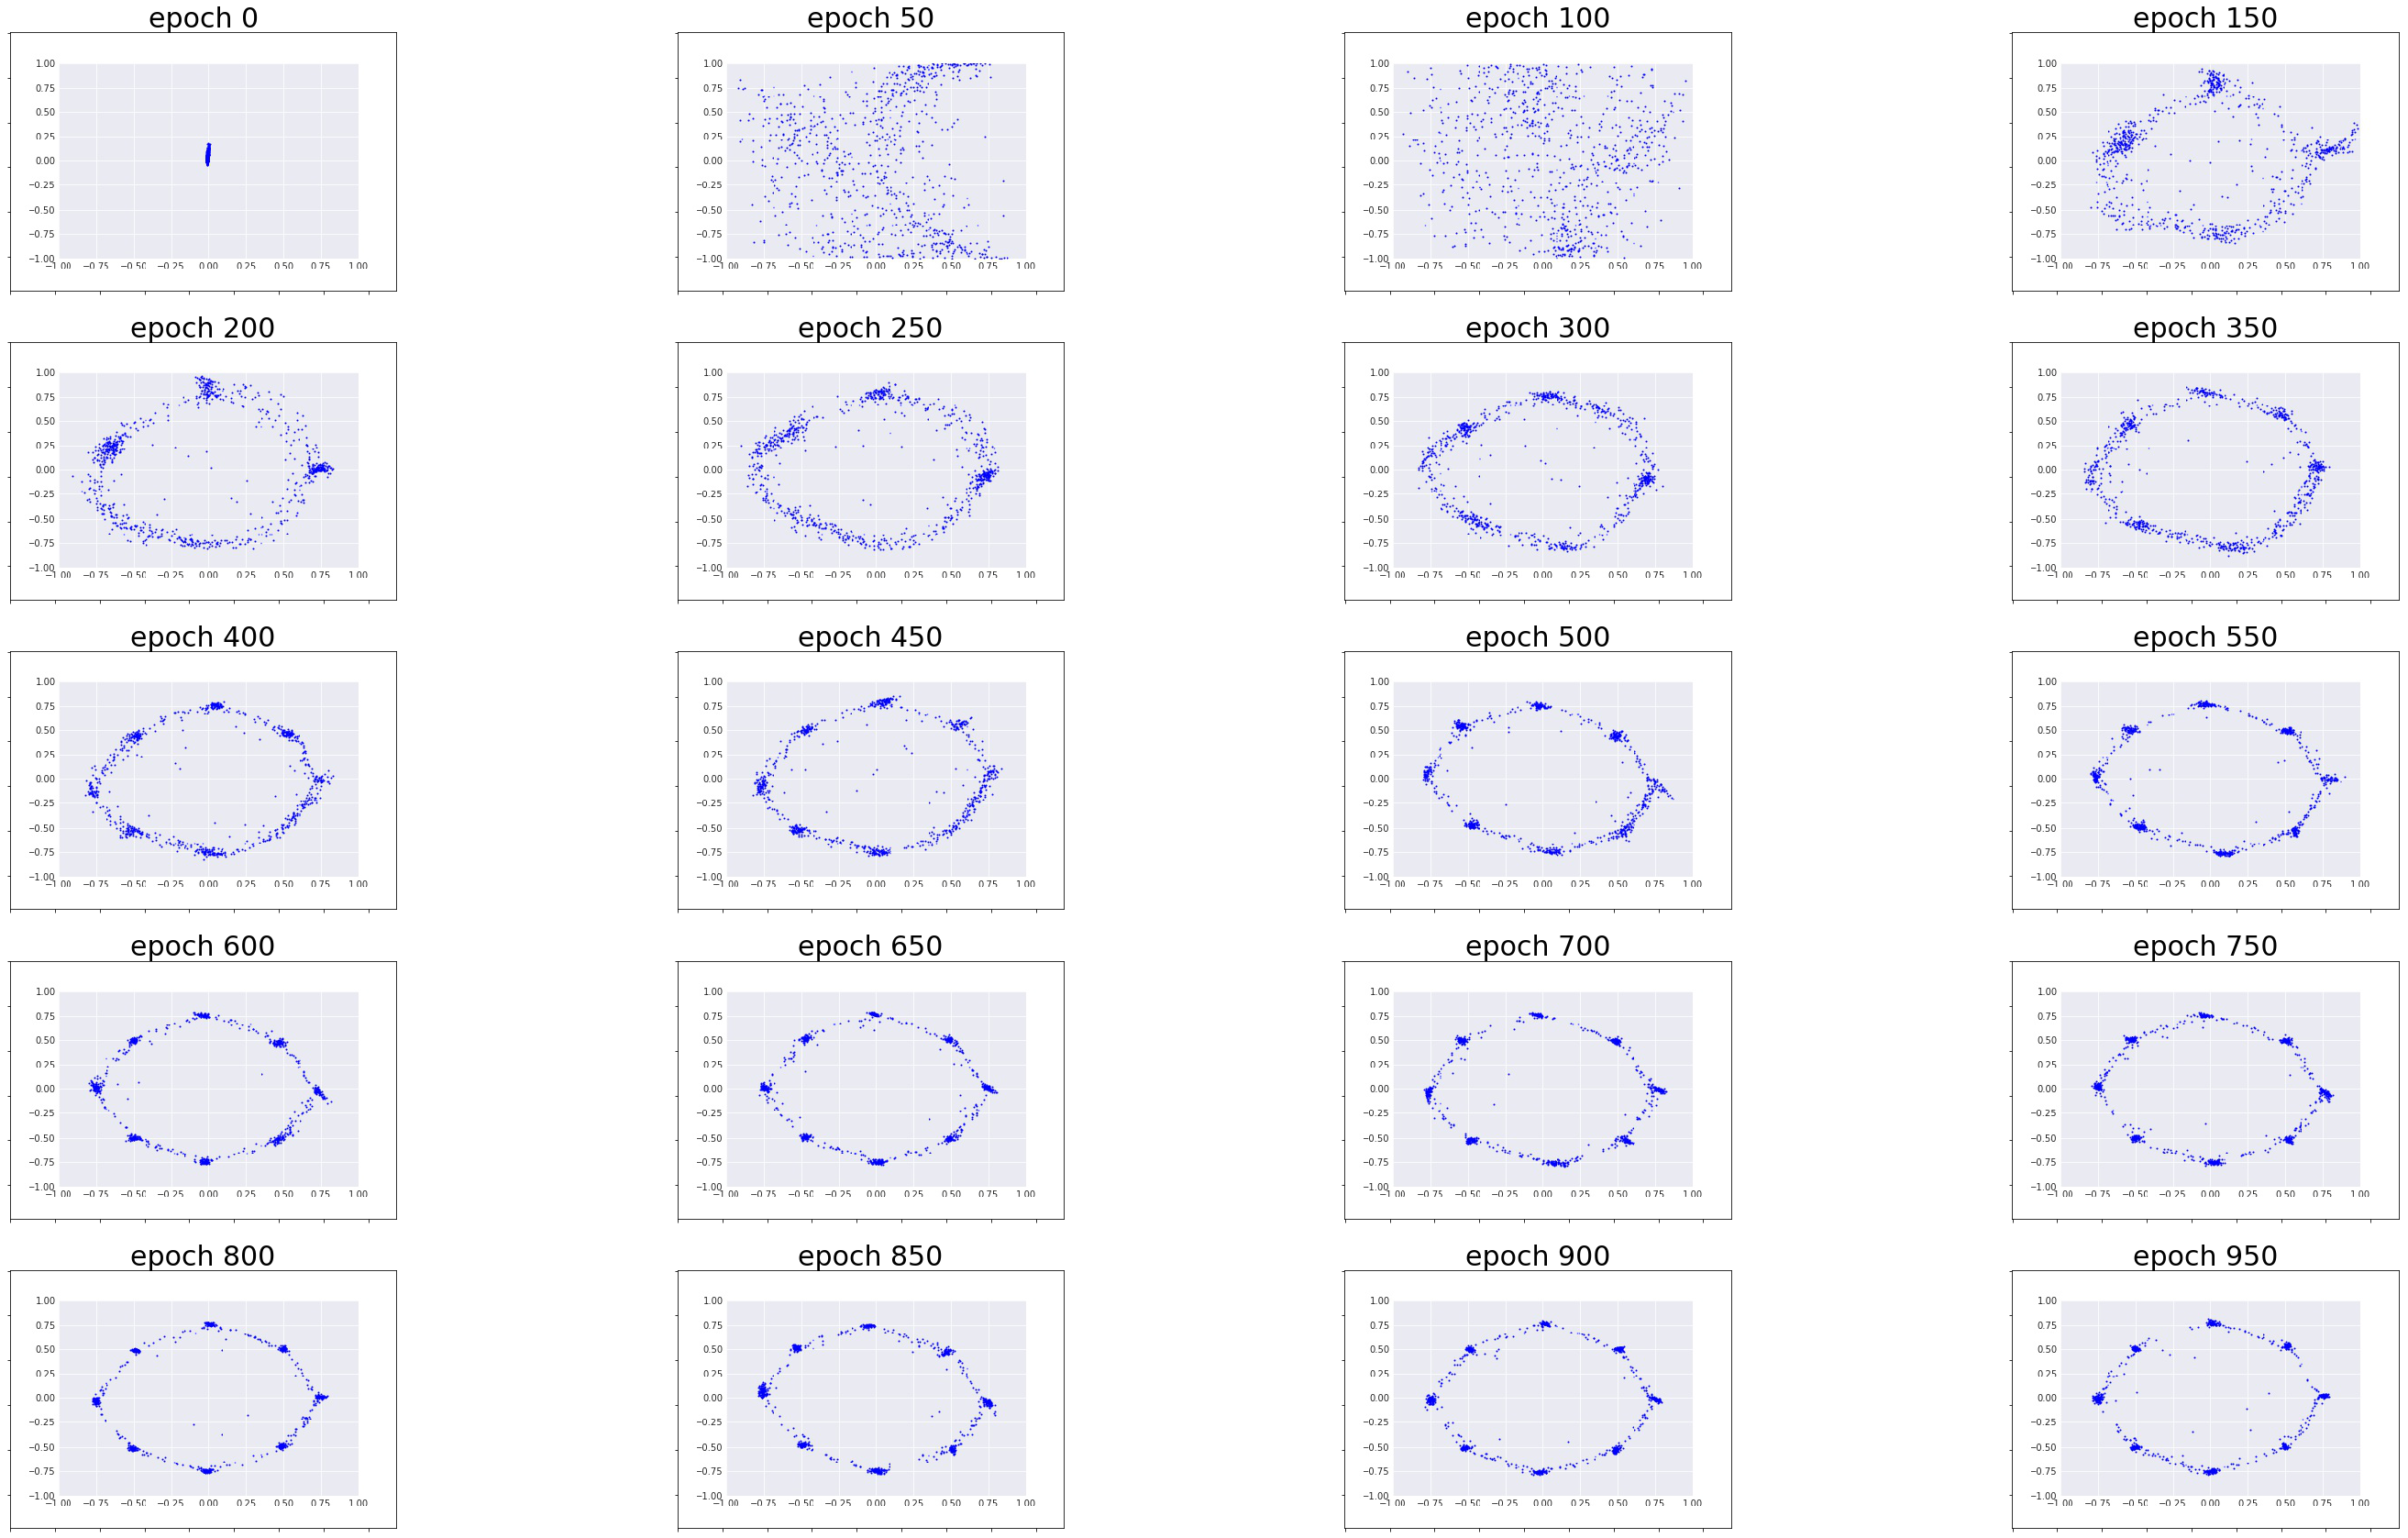

In [7]:
epoch_num = list(range(0,1000,50)) 
plt.figure(figsize=(50,30))
for i,epoch in enumerate(epoch_num):
    img = Image.open('./NormalDist_UnrolledGAN_images/generate_points_epoch{0}.jpg'.format(epoch), 'r')
    # train data plot
    plt.subplot(5, 4, i+1)
    plt.title('epoch {0}'.format(epoch),fontsize=30)
    plt.tick_params(labelbottom='off')
    plt.tick_params(labelleft='off')
    plt.imshow(img)

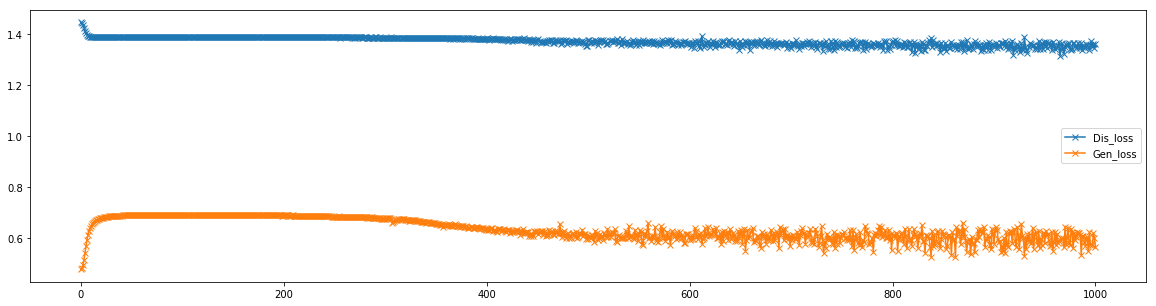

In [8]:
import pandas as pd

df = pd.read_csv('./NormalDist_UnrolledGAN_loss_log.csv', names=['Epoch', 'Dis_loss','Gen_loss'])
plt.figure(figsize=(20, 5))
plt.plot(df['Epoch'],df['Dis_loss'],'-x',label='Dis_loss')
plt.plot(df['Epoch'],df['Gen_loss'],'-x',label='Gen_loss')
plt.legend()
plt.show()
plt.close()

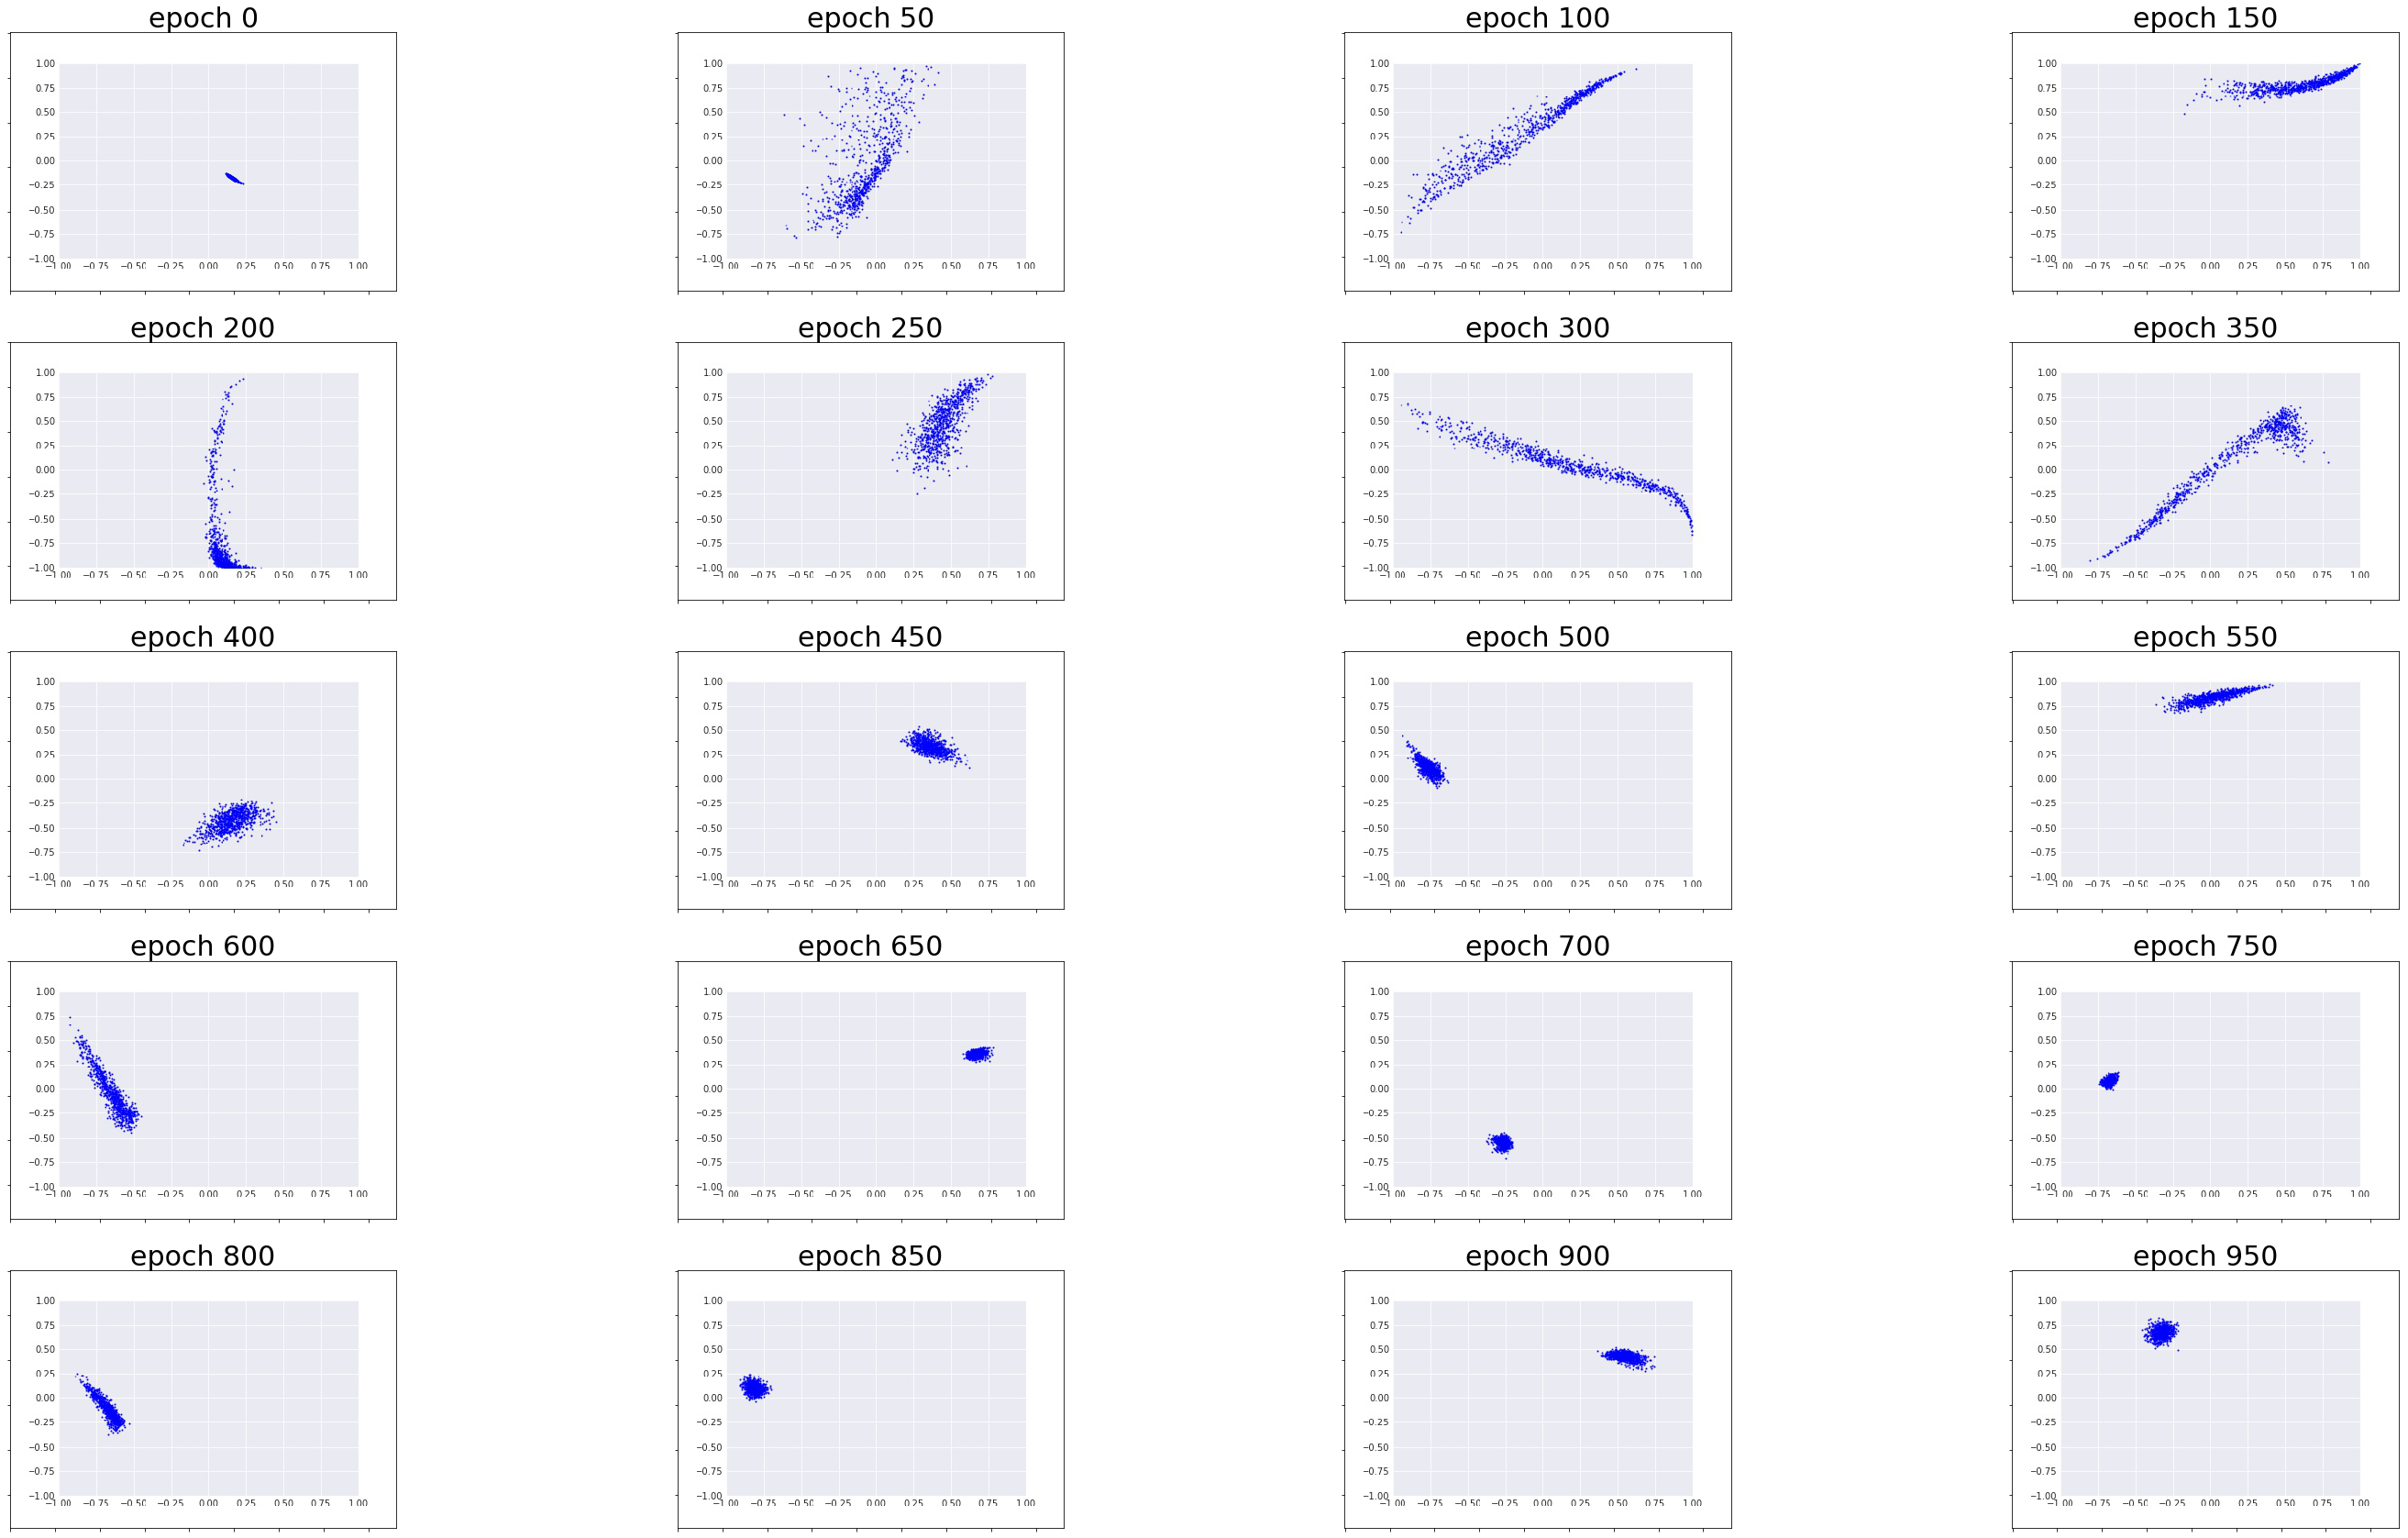

In [9]:
#同じモデル設定でUnrolledを使用しない通常のGANの結果
epoch_num = list(range(0,1000,50)) 
plt.figure(figsize=(50,30))
for i,epoch in enumerate(epoch_num):
    img = Image.open('./NormalDist_GAN_images/generate_points_epoch{0}.jpg'.format(epoch), 'r')
    # train data plot
    plt.subplot(5, 4, i+1)
    plt.title('epoch {0}'.format(epoch),fontsize=30)
    plt.tick_params(labelbottom='off')
    plt.tick_params(labelleft='off')
    plt.imshow(img)

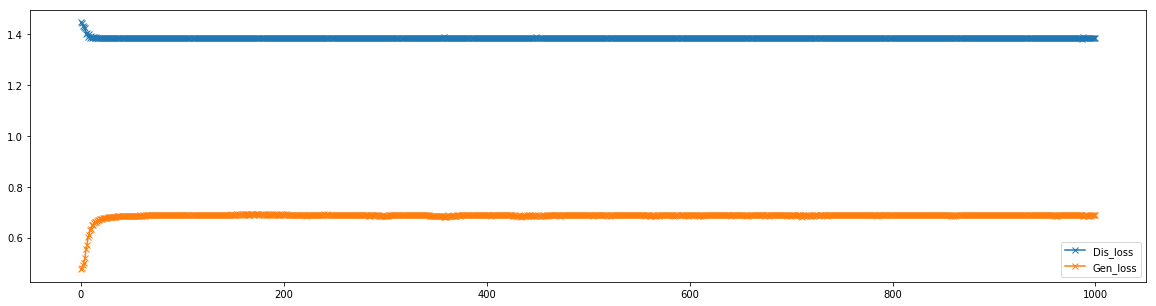

In [10]:
#同じモデル設定でUnrolledを使用しない通常のGANの結果

df = pd.read_csv('./NormalDist_GAN_loss_log.csv', names=['Epoch', 'Dis_loss','Gen_loss'])
plt.figure(figsize=(20, 5))
plt.plot(df['Epoch'],df['Dis_loss'],'-x',label='Dis_loss')
plt.plot(df['Epoch'],df['Gen_loss'],'-x',label='Gen_loss')
plt.legend()
plt.savefig('NormalDist_GAN_loss_log.png')
plt.show()
plt.close()